In [1]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [2]:
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [3]:
F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [4]:
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

In [5]:
# vocab_size：词表大小（即 one-hot 向量的维度）
# num_hiddens：隐藏层神经元数量（RNN 的“记忆容量”）
# device：张量在哪个设备上创建（如 cpu() 或 cuda()）
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size
    # 我们输入和输出都是词的索引（或 one-hot 编码），所以输入输出的维度都是词表大小。

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01
    # 用小的随机数初始化权重矩阵，防止梯度爆炸；偏置初始化为0

    # 隐藏层参数
    W_xh = normal((num_inputs, num_hiddens))  # 输入到隐藏层
    W_hh = normal((num_hiddens, num_hiddens))  # 隐藏到隐藏层
    b_h = torch.zeros(num_hiddens, device=device)  # 隐藏层偏置
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))  # 隐藏到输出层
    b_q = torch.zeros(num_outputs, device=device)  # 输出层偏置
    # 附加梯度 
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)  # 这一步是告诉 PyTorch：这些张量是 可学习的参数，训练时会自动进行反向传播和更新。
    return params

In [6]:
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

In [7]:
def rnn(inputs, state, params):
    # inputs的形状：(时间步数量，批量大小，词表大小)
    # state：前一个时间步的隐藏状态
    # params：所有模型参数
    
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    
    # X的形状：(批量大小，词表大小)
    # 对每个时间步进行计算
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)  # 收集每个时间步的输出
    return torch.cat(outputs, dim=0), (H,)
    # 把 outputs 中每个时间步的输出拼接起来（形状变为 (时间步 × batch_size, vocab_size)）
    # 返回当前隐藏状态 H（放进元组中）

In [8]:
# 搭建模型部分
class RNNModelScratch: #@save
    """从零开始实现的循环神经网络模型"""
    # init构造函数
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn
        # 这些函数之前我们都已经手写定义好，这里作为参数传入，从而让类更通用、更模块化。

    # call方法（模型向前调用）
    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    # begin_state() 方法：初始化隐藏状态
    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [9]:
num_hiddens = 512  # 设置隐藏层的神经元个数为 512，越大模型容量越强，但也越难训练。

net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)

state = net.begin_state(X.shape[0], d2l.try_gpu())
# 初始化隐藏状态 state
# X.shape[0] 是 batch_size
# 返回形状是 (batch_size, num_hiddens) 的隐藏状态张量

Y, new_state = net(X.to(d2l.try_gpu()), state)
# Y: 输出的预测结果（未经过 softmax 的线性层输出）
# new_state: 更新后的隐藏状态

Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

In [10]:
def predict_ch8(prefix, num_preds, net, vocab, device):  #@save
    """在prefix后面生成新字符"""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    
    for y in prefix[1:]:  # 预热期
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
        
    for _ in range(num_preds):  # 预测num_preds步
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
        
    return ''.join([vocab.idx_to_token[i] for i in outputs])  # 最后：把索引变回字符

In [11]:
predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())

'time traveller ywm<unk>yfczbg'

In [12]:
def grad_clipping(net, theta):  #@save
    """裁剪梯度"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [13]:
#@save
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练网络一个迭代周期（定义见第8章）"""
    
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # 训练损失之和,词元数量
    # state：RNN 的隐藏状态（第一次为 None）
    # timer：计时器（记录训练时间）
    # metric：一个简单的“累加器”，用来统计两个指标：累计损失、累计预测词数
    
    for X, Y in train_iter:  # 遍历训练集中每个小批量数据
        # 隐藏状态的初始化或截断
        # 采样方式	                        state 是否初始化	    用法说明
        # 随机采样（use_random_iter=True）	每一批都重新初始化	没有历史信息
        # 顺序采样（use_random_iter=False）	沿用上一批的隐藏状态	模拟长序列记忆，但需 detach() 截断梯度图
        
        if state is None or use_random_iter:
            # 在第一次迭代或使用 随机抽样 时初始化state
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple): # 对顺序分区进行设置
                # 在顺序采样中，我们希望当前 batch 的隐藏状态继承自上一个 batch（保持时间序列的连续性），
                # 但不能让梯度也一路回传到前几个 batch，否则会：
                #     导致梯度爆炸（梯度链太长）
                #     消耗大量显存
                # state对于nn.GRU是个张量
                state.detach_()  # detach_() 的作用是阻止梯度在时间维度上回传太远，避免爆炸或过多内存消耗
            else:
                # state对于nn.LSTM或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()  # 使用 .detach_() 表示「在时间维度上切断反向传播的计算图」，不再追溯前面序列的梯度
       
        y = Y.T.reshape(-1)  # 将目标 Y 拉成一维向量，准备计算交叉熵
        X, y = X.to(device), y.to(device) 
        
        y_hat, state = net(X, state)  # 前向传播
        l = loss(y_hat, y.long()).mean()  # 计算平均损失

        # 优化器更新权重
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)  # 梯度裁剪
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # 因为已经调用了mean函数
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [14]:
#@save
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第8章）"""

    # 定义损失函数为动画器
    loss = nn.CrossEntropyLoss()  # 定义损失函数为交叉熵
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])  
    # Animator：用来绘图展示训练过程中“困惑度（perplexity）”的变化
    
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)  
        # 如果模型是 PyTorch 封装的 nn.Module 类型，就用标准优化器 torch.optim.SGD
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
        # 如果模型是自己从零实现的（例如前面的 RNNModelScratch），就使用手写的 d2l.sgd 函数（从零实现的SGD）
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # 每训练完若干 epoch，会生成以 prefix 开头的预测字符串（长度为50），方便我们观察效果。
    
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        # ppl（perplexity，困惑度）：是 RNN 任务中评估性能的重要指标，越低越好

        # 中途可视化与输出预测结果
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

困惑度 1.0, 87972.7 词元/秒 cuda:0
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


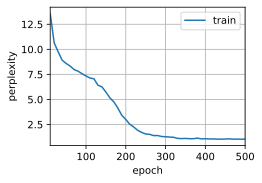

In [15]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

困惑度 1.5, 84048.0 词元/秒 cuda:0
time travellerit s against reason bat of hargut nast and hurry o
travellerit s against reason bat of hargut nast and hurry o


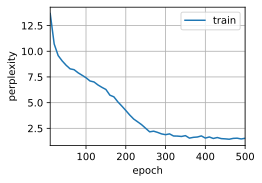

In [16]:
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),
          use_random_iter=True)